In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import arch
import scipy.stats as sps
import scipy as sp
import scipy.optimize as spop
from statsmodels.stats.stattools import durbin_watson

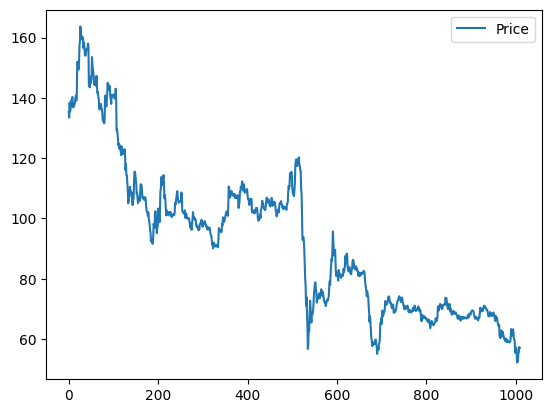

In [3]:
df = pd.read_csv('INPUT_TS.csv')
df.plot()
plt.show()

In [4]:
print(df['Price'].head())

0    135.35
1    133.50
2    138.40
3    135.50
4    136.45
Name: Price, dtype: float64


# Unit root test (Augmented Dickey-Fuller test)
    Null Hypothesis H0 : the time series has a unit root, meaning it is non-stationary.
    Alternate Hypothesis H1: the time series does not have a unit root, meaning it is stationary.

In [5]:
X = df['Price']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.606262
p-value: 0.480447
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


### p-value > 0.05 => time series has a unit root, it is non-stationarity

### Take first difference

In [6]:
X = df['Price']
result = adfuller(X.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.775153
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


### p-value = 0, so we will take the digree d = 1

In [17]:
b = []
for i in range(0,5):
    for j in range(0,5):
            model = ARIMA(df['Price'], order = (i,1,j))
            results_ARIMA = model.fit()
            b.append([results_ARIMA.aic, i, j])
print(min(b), b[b.index(min(b))])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[3968.1223546778906, 4, 0] [3968.1223546778906, 4, 0]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# The lowest value of the criterion AIC was with parameters p=1, q=4, so ARIMA part of my model has order (4,1,0)

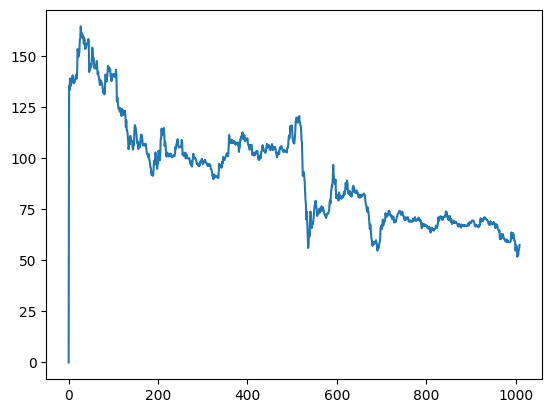

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1010
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -1979.061
Date:                Wed, 13 Dec 2023   AIC                           3968.122
Time:                        17:48:40   BIC                           3992.706
Sample:                             0   HQIC                          3977.462
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1272      0.023      5.510      0.000       0.082       0.172
ar.L2          0.0110      0.021      0.520      0.603      -0.030       0.052
ar.L3         -0.0192      0.025     -0.780      0.4

In [18]:
model = ARIMA(df['Price'], order = (4,1,0))
results_ARIMA = model.fit()
plt.plot(results_ARIMA.fittedvalues) 
plt.show() 
arima_resid = results_ARIMA.resid
print(results_ARIMA.summary())

In [19]:
results_ARIMA.resid.head(10)

0    135.350000
1     -1.850053
2      5.136749
3     -3.498752
4      1.245790
5      1.245458
6      1.095852
7     -0.223684
8      1.240792
9     -2.835643
dtype: float64

In [20]:
print('Durbin-Watson number is ' + str(durbin_watson(arima_resid))+' (in 1.5 - 2.5 interval), so residuals are uncorrelated')

Durbin-Watson number is 1.164216131955622 (in 1.5 - 2.5 interval), so residuals are uncorrelated


p-value is 1.2694824513849312e-74, that means normal distribution of residuals with parameters (0.07417458912846076, 21.089413854625697)


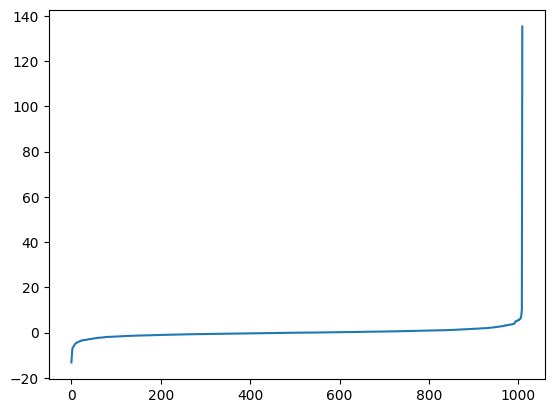

In [21]:
data = pd.DataFrame(arima_resid)[:]
data['rank']=(data[0].rank(method='first'))/(len(data))
data=data.sort_values(by='rank').reset_index(drop=True)
plt.plot(data[0])
plt.show
mean = np.average(data[0])
var = (np.std(data[0]))**2

data['normal'] = sps.norm.cdf (data[0], loc= mean , scale=var)


#Это я проверял критерий Колмогорова-Смирнова на всякий случай
KS_array = abs(data['rank']-data['normal'])
KS = max(KS_array)
KS_p = np.exp(-KS**2*len(data))
print('p-value is '+ str(KS_p) + ', that means normal distribution of residuals \
with parameters ('+str(mean)+', '+str(var)+')')

## Residuals uncorrelated and normally distributed (plots)

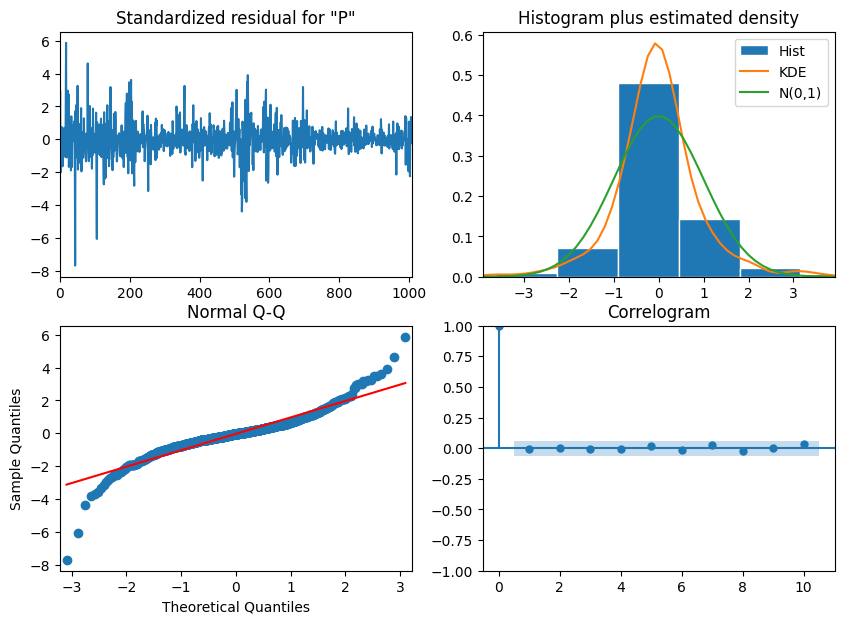

In [35]:
results_ARIMA.plot_diagnostics(figsize=(10,7))
plt.show()

# Estimation of gyperparameters of GARCH part

In [34]:
b = []
for i in range(1,5):
    for j in range(1,5):
            garch = arch.arch_model(arima_resid, p=i, q=j)
            garch_fitted = garch.fit()
            b.append([garch_fitted.aic, i, j])
print(min(b), b[b.index(min(b))])
#garch = arch.arch_model(arima_resid, p=1, q=1)
#garch_fitted = garch.fit()
#print(garch_fitted.aic)
#garch_fitted.plot()
plt.show()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3183898082.522871
Iteration:      2,   Func. Count:     14,   Neg. LLF: 551944775.4353132
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2021.9175254687495
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1950.9709284662638
Iteration:      5,   Func. Count:     32,   Neg. LLF: 1950.7597674229955
Iteration:      6,   Func. Count:     38,   Neg. LLF: 1886.6610273343572
Iteration:      7,   Func. Count:     44,   Neg. LLF: 1882.8808135299557
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1932.8504600664953
Iteration:      9,   Func. Count:     56,   Neg. LLF: 1924.48986820366
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1930.8087123384453
Iteration:     11,   Func. Count:     68,   Neg. LLF: 1934.5497442342753
Iteration:     12,   Func. Count:     74,   Neg. LLF: 1935.7150614078726
Iteration:     13,   Func. Count:     80,   Neg. LLF: 6399.398134892198
Iteration:     14,   Func. Count:     92,   Neg. LLF: 79

Iteration:      5,   Func. Count:     47,   Neg. LLF: 2188.273667840035
Iteration:      6,   Func. Count:     56,   Neg. LLF: 2045.2461268777442
Iteration:      7,   Func. Count:     65,   Neg. LLF: 2203.8456935331387
Iteration:      8,   Func. Count:     74,   Neg. LLF: 1891.9785378818424
Iteration:      9,   Func. Count:     83,   Neg. LLF: 2431.3826036545265
Iteration:     10,   Func. Count:     92,   Neg. LLF: 1884.33402008502
Iteration:     11,   Func. Count:    100,   Neg. LLF: 1884.5147448847927
Iteration:     12,   Func. Count:    109,   Neg. LLF: 1926.3435794401398
Iteration:     13,   Func. Count:    118,   Neg. LLF: 1883.9179009428763
Iteration:     14,   Func. Count:    126,   Neg. LLF: 1883.9144897158365
Iteration:     15,   Func. Count:    134,   Neg. LLF: 1883.9131271940973
Iteration:     16,   Func. Count:    142,   Neg. LLF: 1883.912994306766
Iteration:     17,   Func. Count:    150,   Neg. LLF: 1883.9129938539788
Optimization terminated successfully    (Exit mode 0)
 

# The lowest value of the criterion AIC was with parameters r=2, s=4, so GARCH part of my model has order (2,4)

In [38]:
garch = arch.arch_model(arima_resid, p=2, q=4)
garch_fitted = garch.fit()
print(garch_fitted.summary())

Iteration:      1,   Func. Count:     10,   Neg. LLF: 852704060.1962852
Iteration:      2,   Func. Count:     22,   Neg. LLF: 618429109.5438032
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2075.9095505228033
Iteration:      4,   Func. Count:     42,   Neg. LLF: 485581294.44489294
Iteration:      5,   Func. Count:     52,   Neg. LLF: 2034.8682405573836
Iteration:      6,   Func. Count:     62,   Neg. LLF: 1972.8059308107495
Iteration:      7,   Func. Count:     72,   Neg. LLF: 2175.790821058781
Iteration:      8,   Func. Count:     82,   Neg. LLF: 1914.8383883138188
Iteration:      9,   Func. Count:     92,   Neg. LLF: 1904.1674035913181
Iteration:     10,   Func. Count:    102,   Neg. LLF: 1912.8897594761816
Iteration:     11,   Func. Count:    112,   Neg. LLF: 1916.0568963559642
Iteration:     12,   Func. Count:    122,   Neg. LLF: 1863.454849973953
Iteration:     13,   Func. Count:    131,   Neg. LLF: 1863.1418225094915
Iteration:     14,   Func. Count:    140,   Neg. LLF: 1

In [33]:
type(results_ARIMA)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

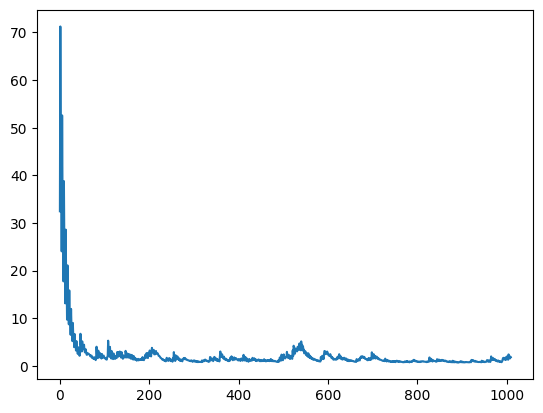

In [32]:
plt.plot(garch_fitted.conditional_volatility)